# [GD_10]U_Net  
----  
목차  
 - 전처리  
 - U_Net  
 - U_Net++  
 - 그래프 비교



In [1]:
pip list | grep albumentations

albumentations                0.1.12


In [2]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
슝=3


In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

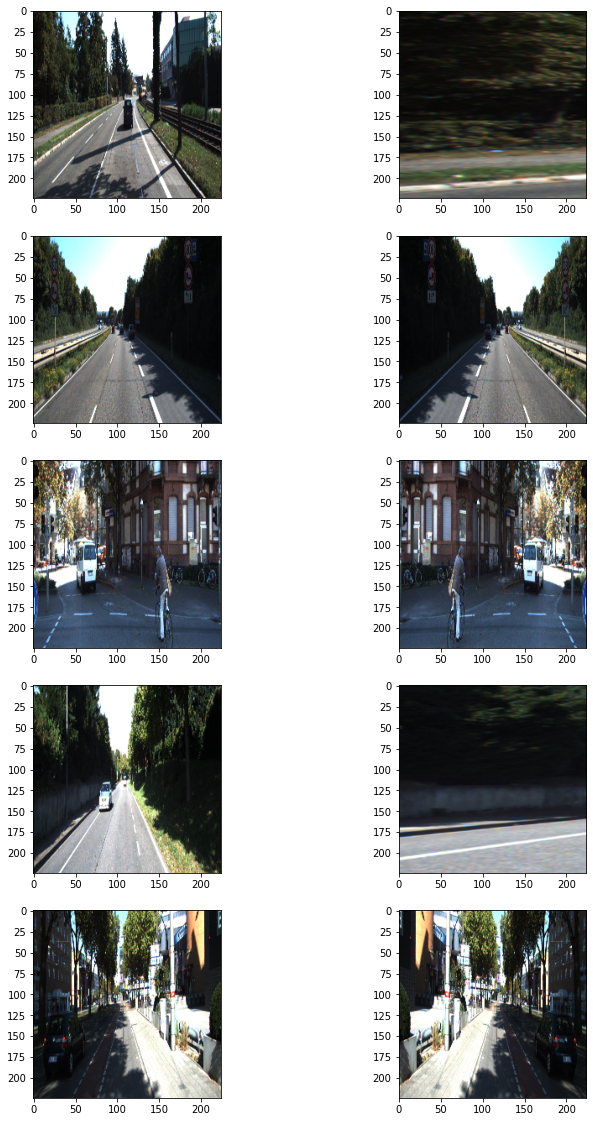

In [4]:
dir_path = '/content/drive/MyDrive/colab/segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [7]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='elu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='elu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='elu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='elu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='elu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='elu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='elu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='elu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='elu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='elu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='elu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='elu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='elu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='elu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [8]:
model_path = '/content/drive/MyDrive/colab/segmentation/data/training/seg_model_unet.h5'
EPOCHS = 100

unet = build_model()
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

unet.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 18s 420ms/step - loss: 0.2079 - accuracy: 0.9502 - val_loss: 0.0734 - val_accuracy: 0.9584
Epoch 2/100
22/22 [==============================] - 8s 371ms/step - loss: 0.0691 - accuracy: 0.9689 - val_loss: 0.0665 - val_accuracy: 0.9627
Epoch 3/100
22/22 [==============================] - 8s 371ms/step - loss: 0.0575 - accuracy: 0.9747 - val_loss: 0.0667 - val_accuracy: 0.9694
Epoch 4/100
22/22 [==============================] - 8s 375ms/step - loss: 0.0494 - accuracy: 0.9792 - val_loss: 0.0464 - val_accuracy: 0.9779
Epoch 5/100
22/22 [==============================] - 8s 376ms/step - loss: 0.0486 - accuracy: 0.9797 - val_loss: 0.0389 - val_accuracy: 0.9842
Epoch 6/100
22/22 [==============================] - 8s 378ms/step - loss: 0.0405 - accuracy: 0.9828 - val_loss: 0.0424 - val_accuracy: 0.9855
Epoch 7/100
22/22 [==============================] - 8s 380ms/step - loss: 0.0370 - accuracy: 0.9844 - val_loss: 0.0352 - val_accuracy: 0.983

In [9]:
def get_output_image(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

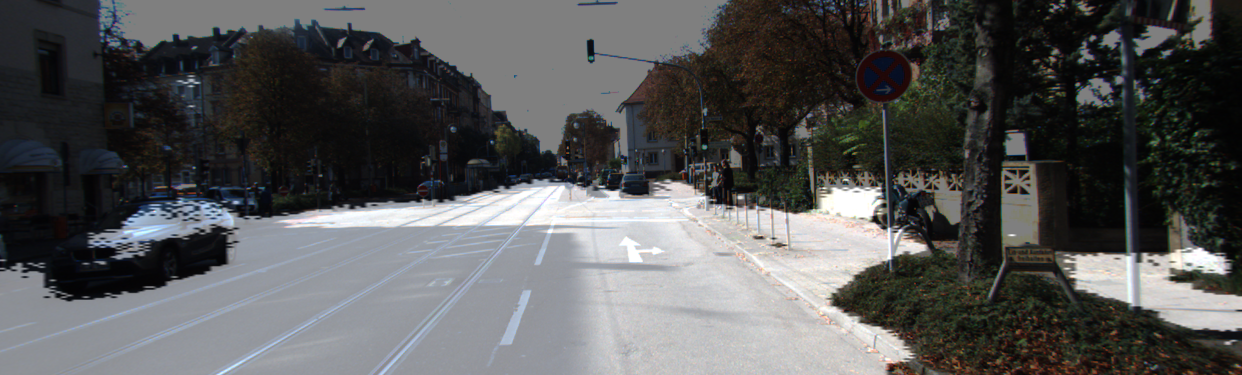

In [10]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 이게 유넷..
get_output_image(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.772806


0.7728061477441746

 - 기본 모델의 성능이 좋다.

In [14]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'
    dropout_rate = 0.5
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same')(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same')(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [15]:
def Nest_Net(img_rows, img_cols, color_type=3):

    nb_filter = [64,128,256,512,1024]
    act = 'elu'
    
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
    
    conv0_0 = standard_unit(img_input, stage='00', nb_filter=nb_filter[0])
    pool0 = MaxPooling2D((2, 2), strides=(2, 2), name='pool0')(conv0_0)

    conv1_0 = standard_unit(pool0, stage='10', nb_filter=nb_filter[1])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_0)

    up0_1 = Conv2DTranspose(nb_filter[0], 2, activation = act, strides=(2, 2), name='up01', padding='same', kernel_initializer = 'he_normal')(conv1_0)
    conv0_1 = concatenate([up0_1, conv0_0], name='merge01', axis=bn_axis)
    conv0_1 = standard_unit(conv0_1, stage='01', nb_filter=nb_filter[0])

    conv2_0 = standard_unit(pool1, stage='20', nb_filter=nb_filter[2])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_0)

    up1_1 = Conv2DTranspose(nb_filter[1], 2, activation = act, strides=(2, 2), name='up11', padding='same', kernel_initializer = 'he_normal')(conv2_0)
    conv1_1 = concatenate([up1_1, conv1_0], name='merge11', axis=bn_axis)
    conv1_1 = standard_unit(conv1_1, stage='11', nb_filter=nb_filter[1])

    up0_2 = Conv2DTranspose(nb_filter[0], 2, activation = act, strides=(2, 2), name='up02', padding='same', kernel_initializer = 'he_normal')(conv1_1)
    conv0_2 = concatenate([up0_2, conv0_1, conv0_0], name='merge02', axis=bn_axis)
    conv0_2 = standard_unit(conv0_2, stage='02', nb_filter=nb_filter[0])

    conv3_0 = standard_unit(pool2, stage='30', nb_filter=nb_filter[3])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_0)

    up2_1 = Conv2DTranspose(nb_filter[2], 2, activation = act, strides=(2, 2), name='up21', padding='same', kernel_initializer = 'he_normal')(conv3_0)
    conv2_1 = concatenate([up2_1, conv2_0], name='merge21', axis=bn_axis)
    conv2_1 = standard_unit(conv2_1, stage='21', nb_filter=nb_filter[2])

    up1_2 = Conv2DTranspose(nb_filter[1], 2, activation = act, strides=(2, 2), name='up12', padding='same', kernel_initializer = 'he_normal')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_0, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[1])

    up0_3 = Conv2DTranspose(nb_filter[0], 2, activation = act, strides=(2, 2), name='up03', padding='same', kernel_initializer = 'he_normal')(conv1_2)
    conv0_3 = concatenate([up0_3, conv0_0, conv0_1, conv0_2], name='merge03', axis=bn_axis)
    conv0_3 = standard_unit(conv0_3, stage='03', nb_filter=nb_filter[0])

    conv4_0 = standard_unit(pool3, stage='40', nb_filter=nb_filter[4])

    up3_1 = Conv2DTranspose(nb_filter[3], 2, activation = act, strides=(2, 2), name='up31', padding='same', kernel_initializer = 'he_normal')(conv4_0)
    conv3_1 = concatenate([up3_1, conv3_0], name='merge31', axis=bn_axis)
    conv3_1 = standard_unit(conv3_1, stage='31', nb_filter=nb_filter[3])

    up2_2 = Conv2DTranspose(nb_filter[2], 2, activation = act, strides=(2, 2), name='up22', padding='same', kernel_initializer = 'he_normal')(conv3_0)
    conv2_2 = concatenate([up2_2, conv2_0, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[2])

    up1_3 = Conv2DTranspose(nb_filter[1], 2, activation = act, strides=(2, 2), name='up13', padding='same', kernel_initializer = 'he_normal')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_0, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[1])

    up0_4 = Conv2DTranspose(nb_filter[0], 2, activation = act, strides=(2, 2), name='up04', padding='same', kernel_initializer = 'he_normal')(conv1_3)
    conv0_4 = concatenate([up0_4, conv0_0, conv0_1, conv0_2, conv0_3], name='merge04', axis=bn_axis)
    conv0_4 = standard_unit(conv0_4, stage='04', nb_filter=nb_filter[0])
    
    output_1 = Conv2D(2, 3, activation='elu', name='output_1', padding='same',kernel_initializer='he_normal')(conv0_1)
    output_2 = Conv2D(2, 3, activation='elu', name='output_2', padding='same',kernel_initializer='he_normal')(conv0_2)
    output_3 = Conv2D(2, 3, activation='elu', name='output_3', padding='same',kernel_initializer='he_normal')(conv0_3)
    output_4 = Conv2D(2, 3, activation='elu', name='output_4', padding='same',kernel_initializer='he_normal')(conv0_4)

    nestnet_output_1 = Conv2D(1, 1, activation='sigmoid', name='nest_output_1', kernel_initializer = 'he_normal')(output_1)
    nestnet_output_2 = Conv2D(1, 1, activation='sigmoid', name='nest_output_2', kernel_initializer = 'he_normal')(output_2)
    nestnet_output_3 = Conv2D(1, 1, activation='sigmoid', name='nest_output_3', kernel_initializer = 'he_normal')(output_3)
    nestnet_output_4 = Conv2D(1, 1, activation='sigmoid', name='nest_output_4', kernel_initializer = 'he_normal')(output_4)
    
    outputs_list= [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4]
    avg_output = tf.keras.layers.Average()(outputs_list)
    
    model = Model(inputs=img_input, outputs = avg_output)

    return model

In [16]:
U_plus = Nest_Net(224,224,3)
U_plus.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv00_1 (Conv2D)              (None, 224, 224, 64  1792        ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 dp00_1 (Dropout)               (None, 224, 224, 64  0           ['conv00_1[0][0]']               
                                )                                                           

In [17]:
U_plus_path = '/content/drive/MyDrive/colab/segmentation/data/training/seg_model_unet_plus.h5'

U_plus.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])
U_plus_history = U_plus.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

U_plus.save(U_plus_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 32s 1s/step - loss: 0.5038 - accuracy: 0.8705 - val_loss: 0.2934 - val_accuracy: 0.9661
Epoch 2/100
22/22 [==============================] - 22s 989ms/step - loss: 0.2608 - accuracy: 0.9696 - val_loss: 0.2431 - val_accuracy: 0.9661
Epoch 3/100
22/22 [==============================] - 22s 993ms/step - loss: 0.2010 - accuracy: 0.9697 - val_loss: 0.1952 - val_accuracy: 0.9661
Epoch 4/100
22/22 [==============================] - 22s 994ms/step - loss: 0.1584 - accuracy: 0.9747 - val_loss: 0.1557 - val_accuracy: 0.9661
Epoch 5/100
22/22 [==============================] - 22s 994ms/step - loss: 0.1529 - accuracy: 0.9724 - val_loss: 0.1480 - val_accuracy: 0.9661
Epoch 6/100
22/22 [==============================] - 22s 993ms/step - loss: 0.1493 - accuracy: 0.9733 - val_loss: 0.1645 - val_accuracy: 0.9661
Epoch 7/100
22/22 [==============================] - 22s 993ms/step - loss: 0.1528 - accuracy: 0.9687 - val_loss: 0.1453 - val_accuracy: 0.

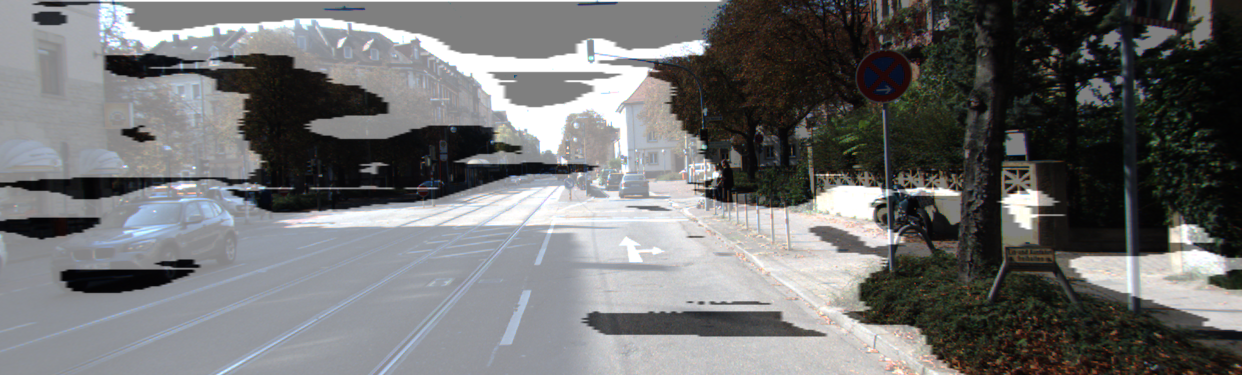

In [24]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 이게 ++ 내일다시 ㅎㅎ

get_output_image(
     U_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [19]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     U_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.455923


0.4559229170602683

U_Net++인데 아쉬운 모습

In [20]:
def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(dir_path, f'{model_name}_Result.png'))  # 저장
    plt.show()

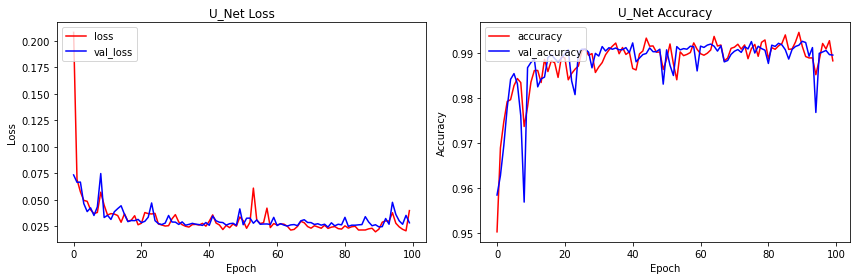

In [21]:
draw_unet_history(unet_history, 'U_Net')

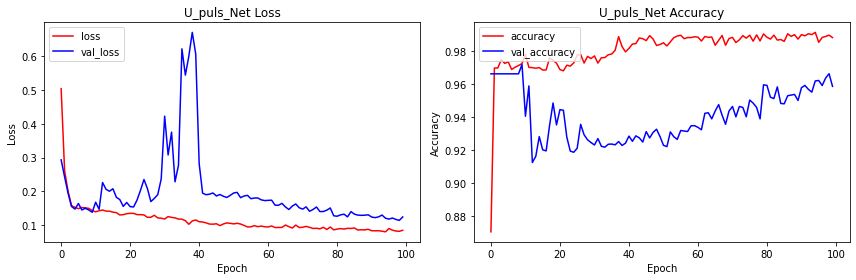

In [22]:
draw_unet_history(U_plus_history, 'U_puls_Net')

### 회고  
----  
마지막 그래프를 보면 U_Net++에서 accuracy가 한번 크게 하락한 후에 accuracy가 많이 올라오지 못한다. 왜그런지는 모르겠지만 U_Net의 성능이 더 좋게 나옴. 잘못 구현한건가 싶은 생각이 들긴하는데 skip connection을 다 연결했고, 실행과정에서 에러도 나지 않은 걸로 보아 이미지 사이즈에 맞게 연결된 것 같은데도 이러한 결과를 보인다. 그래도 U_Net++의 구조를 자세히 보고 구현해볼 수 있는 기회가 되었다고 생각해서 만족스럽다. epochs를 좀 더 늘리면 더 나은 결과를 볼 수 있었을까 싶기도 하다.